In [51]:
%matplotlib inline
import os, random, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

from utils.constants import *
from utils.generator import Generator
from utils.discriminator import Discriminator
from utils.image_transform import ImageTransform
# from utils.upsample import Upsample
# from utils.downsample import Downsample

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))
PATH = "./saved_models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cpu


In [52]:
img_paths = []
for class_path in [os.path.join(dataroot,class_name) for class_name in os.listdir(dataroot)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        img_paths.append(class_img_path)

print("There are {} style images in Van Gogh Paintings Dataset".format(len(img_paths)))

There are 2025 style images in Van Gogh Paintings Dataset


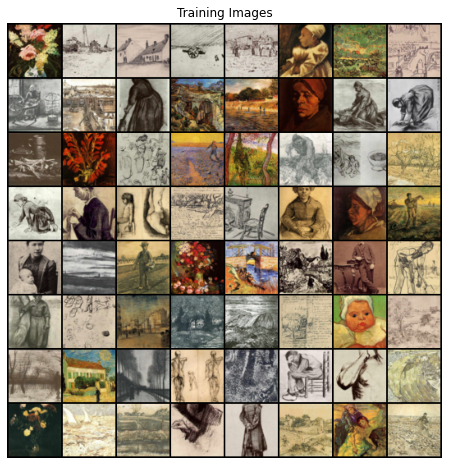

In [62]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

real_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [71]:
print(type(dataloader))
print(type(real_batch))
print(len(real_batch))
print(real_batch[0].shape, real_batch[1].shape)

# for i, data in enumerate(dataloader):
#     print('Data:', data[0].shape, data[1].shape)

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'list'>
2
torch.Size([128, 3, 64, 64]) torch.Size([128])


In [45]:
# weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [48]:
net_g = Generator()
# net_g.apply(weights_init)

print(net_g.size())

AttributeError: 'Generator' object has no attribute 'size'

In [44]:
net_d = Discriminator()

print(net_d)

Discriminator(
  (block): Sequential(
    (0): Downsample(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Downsample(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Downsample(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affi

In [ ]:
def weights_init(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>

In [ ]:
# Config  -----------------------------------------------------------------
# data_dir = '../input/gan-getting-started'
transform = ImageTransform(img_size=256)
batch_size = 1
lr = {
    'G': 0.0002,
    'D': 0.0002
}
epoch = 160
seed = 42
reconstr_w = 10
id_w = 5
seed_everything(seed)

# DataModule  -----------------------------------------------------------------
dm = MonetDataModule(dataroot, transform, batch_size, seed=seed)

G_basestyle = CycleGAN_Unet_Generator()
G_stylebase = CycleGAN_Unet_Generator()
D_base = CycleGAN_Discriminator()
D_style = CycleGAN_Discriminator()

# Init Weight  --------------------------------------------------------------
for net in [G_basestyle, G_stylebase, D_base, D_style]:
    init_weights(net, init_type='normal')

# LightningModule  --------------------------------------------------------------
model = CycleGAN_LightningSystem(G_basestyle, G_stylebase, D_base, D_style, 
                                 lr, transform, reconstr_w, id_w)

# Trainer  --------------------------------------------------------------
trainer = Trainer(
    logger=False,
    max_epochs=epoch,
    gpus=1,
    checkpoint_callback=False,
    reload_dataloaders_every_epoch=True,
    num_sanity_val_steps=0,  # Skip Sanity Check
)


# Train
trainer.fit(model, datamodule=dm)